# Mail count prediction model

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as st
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
plt.style.use('ggplot')
sns.set()

## Source data

In [3]:
dtype = {'point1': str, 'point2': str, 'point3': str, 'point4': str}
df = pd.read_csv('mails.csv', dtype=dtype, parse_dates=['date1', 'date2', 'date3', 'date4'])

In [4]:
df

,point1,date1,point2,date2,point3,date3,point4,date4
0,NaN,NaT,NaN,NaT,43,2020-01-14 11:39:46,39,2020-01-14 15:41:25
1,NaN,NaT,NaN,NaT,42,2020-04-12 10:17:18,39,2020-04-12 15:56:51
2,NaN,NaT,NaN,NaT,41,2020-04-04 09:50:23,39,2020-04-04 15:25:24
3,NaN,NaT,NaN,NaT,42,2020-03-17 22:14:00,39,2020-03-18 09:05:05
4,NaN,NaT,NaN,NaT,42,2020-02-13 03:39:31,39,2020-02-13 13:44:41
...,...,...,...,...,...,...,...,...
14932,NaN,NaT,NaN,NaT,20,2020-02-12 02:22:57,39,2020-02-19 19:01:40
14933,NaN,NaT,NaN,NaT,8,2020-03-03 17:41:05,39,2020-03-06 14:06:55
14934,NaN,NaT,NaN,NaT,8,2020-03-03 11:38:27,39,2020-03-11 15:57:05
14935,NaN,NaT,NaN,NaT,8,2020-03-03 17:30:18,39,2020-03-11 15:51:01


Each row corresponds to a mail:
- pointN - id of a Nth point in a mail delivery route
- dateN - arrival date and time of a mail at pointN

A destination point (point4) of all mails is the same.

## Descriptive statistics

Statistics for delivery time in days:
- delta14 - from point1 to point4
- delta24 - from point2 to point4
- delta34 - from point3 to point4

In [5]:
# Calculate mail delivery time from points 1, 2, 3 to point 4 (in days)
df['delta14'] = (df['date4'] - df['date1']) / np.timedelta64(1, 'D')
df['delta24'] = (df['date4'] - df['date2']) / np.timedelta64(1, 'D')
df['delta34'] = (df['date4'] - df['date3']) / np.timedelta64(1, 'D')

In [6]:
df.describe()

,delta14,delta24,delta34
count,5776.000000,5694.000000,12954.000000
mean,6.266635,5.374829,2.116183
std,3.349485,3.488830,3.820960
min,0.748032,-63.459780,-56.094606
25%,4.136563,3.735987,0.401586
50%,5.688652,5.051013,0.762772
75%,7.604288,6.702755,1.481589
max,54.243252,53.720440,49.972049


Remove mails with a negative delivery time:

In [7]:
df = df[~(df['delta14'] < 0) & ~(df['delta24'] < 0) & ~(df['delta34'] < 0)]
df.describe()

,delta14,delta24,delta34
count,5708.000000,5626.000000,12771.000000
mean,6.288262,5.480219,2.198490
std,3.332776,2.854029,3.670573
min,0.748032,0.680486,0.083472
25%,4.171889,3.791209,0.413490
50%,5.711308,5.080775,0.777222
75%,7.612951,6.721982,1.559271
max,54.243252,53.720440,49.972049


Fit Exponential distribution:

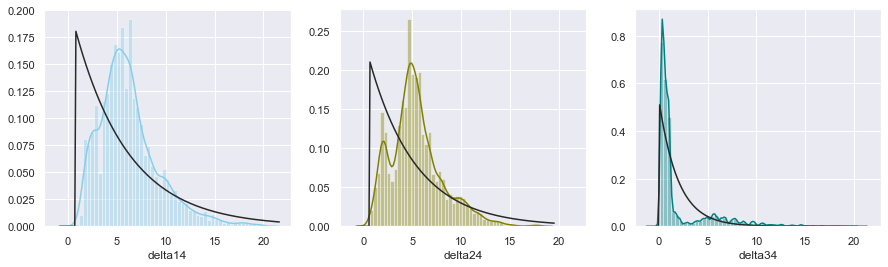

In [8]:
filtered = df[~(df['delta14'] > 20) & ~(df['delta24'] > 20) & ~(df['delta34'] > 20)]
f, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
sns.distplot(filtered['delta14'], color='skyblue', ax=axes[0], fit=st.expon)
sns.distplot(filtered['delta24'], color='olive', ax=axes[1], fit=st.expon)
sns.distplot(filtered['delta34'], color='teal', ax=axes[2], fit=st.expon);

Fit Gamma distribution:

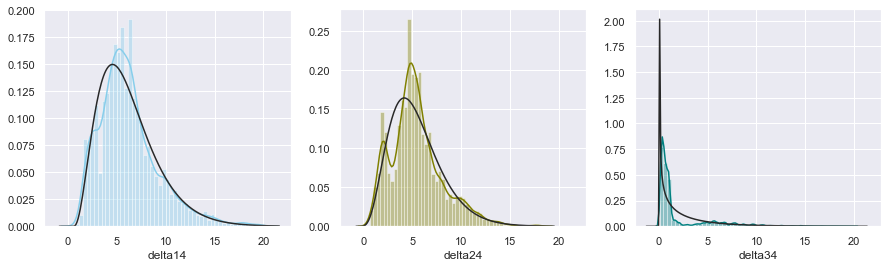

In [9]:
filtered = df[~(df['delta14'] > 20) & ~(df['delta24'] > 20) & ~(df['delta34'] > 20)]
f, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
sns.distplot(filtered['delta14'], color='skyblue', ax=axes[0], fit=st.gamma)
sns.distplot(filtered['delta24'], color='olive', ax=axes[1], fit=st.gamma)
sns.distplot(filtered['delta34'], color='teal', ax=axes[2], fit=st.gamma);

Delta14 and delta24 has Gamma distribution, because there are several intermediate points between point1 (point2) and point4? So we sum several Exponential distributions (for Poisson processes) and get Gamma distribution?

In [10]:
# Tried to fit Erlang distribution, seems it doesn't work. It should be similar to Gamma

# filtered = df[~(df['delta14'] > 20) & ~(df['delta24'] > 20) & ~(df['delta34'] > 20)]#.copy()
# filtered['delta14'] = filtered['delta14'].round()
# filtered['delta24'] = filtered['delta24'].round()
# filtered['delta34'] = filtered['delta34'].round()
# f, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
# sns.distplot(filtered['delta14'], color='skyblue', ax=axes[0], fit=st.erlang)
# sns.distplot(filtered['delta24'], color='olive', ax=axes[1], fit=st.erlang)
# sns.distplot(filtered['delta34'], color='teal', ax=axes[2], fit=st.erlang);
# #st.erlang.fit(filtered['delta14'].dropna().round().astype(int).ravel())

## Model limitations

For simplicity, we will only use date1. Date2 and date3 can be used in a similar way to improve model quality.

There is no train data for some source points (point1). So a total predicted mail count + delayed mail count is less than total actual mail count. Because we don't make any prediction for mails send from such a point1. We could use mean statistics (calculated across all source points) for these point1.

## Data preparation

In [11]:
train_start_date = pd.to_datetime('2020-02-01')
train_end_date = pd.to_datetime('2020-02-29')
test_start_date = pd.to_datetime('2020-03-01')
test_end_date = pd.to_datetime('2020-03-14')
train_range = pd.date_range(train_start_date, train_end_date, freq='D', name='date')
test_range = pd.date_range(test_start_date, test_end_date, freq='D', name='date')

Train and test data:

In [12]:
cond = df['date1'].dt.date.between(train_start_date, train_end_date) & ~df['date4'].isna()
cols = ['point1', 'date1', 'date4']
data = df[cond][cols].reset_index(drop=True)
data

,point1,date1,date4
0,5,2020-02-02 01:34:46,2020-02-06 16:31:25
1,13,2020-02-06 01:05:30,2020-02-11 11:56:51
2,13,2020-02-07 03:12:48,2020-02-11 11:48:34
3,13,2020-02-01 09:33:12,2020-02-04 14:09:38
4,5,2020-02-03 01:24:34,2020-02-05 11:50:29
...,...,...,...
1252,9,2020-02-13 14:19:50,2020-02-17 18:20:48
1253,13,2020-02-24 21:19:25,2020-03-03 10:42:22
1254,9,2020-02-26 01:40:39,2020-03-03 11:09:25
1255,21,2020-02-03 22:20:23,2020-02-11 12:26:14


Point1 and date1 are predictors. Date4 is a dependent variable.

In [13]:
def fit(X_train, y_train, f):
    deltas = pd.DataFrame({
        'point1': X_train['point1'],
        'delta14': (y_train - X_train['date1']).dt.total_seconds()
    })
    return deltas.groupby('point1')['delta14'].apply(f)

def predict(X_test, params, f):
    return X_test.join(params, on='point1', how='inner') \
        .apply(f, axis=1) \
        .rename('date4')

# def test(y_true, y_pred):
#     y_true_count = y_true.groupby(y_true.dt.date).count().reindex(test_range, fill_value=0)
#     y_pred_count = y_pred.groupby(y_pred.dt.date).count().reindex(test_range, fill_value=0)
#     test_count(y_true_count, y_pred_count)
#     delayed = y_pred[y_pred.dt.date <= train_end_date]
#     print('Found %d delayed mails:\n%s' % (len(delayed), delayed))

def test_count(y_true_count, y_pred_count):
    result = pd.DataFrame({'actual': y_true_count, 'predicted': y_pred_count})
    ax = result.plot.bar(figsize=(12,3.5), rot=30)
    ax.set_title('Mail count')
    ax.set_xticklabels(result.index.strftime('%Y-%m-%d'))
    plt.show()

    rmse = np.sqrt(mean_squared_error(y_true_count, y_pred_count))
    print('Root Mean Squared Error: %g' % rmse)
    
    print('Total mail count (actual, predicted): %d, %d' % (y_true_count.sum(), y_pred_count.sum()))

In [14]:
X = data.drop(columns='date4')
y = data['date4']

In [15]:
train_cond = data['date4'].dt.date.between(train_start_date, train_end_date)
test_cond = data['date4'].dt.date.between(test_start_date, test_end_date)
X_train = X[train_cond]
y_train = y[train_cond]
X_test = X[test_cond]
y_test = y[test_cond]

Maximum mail send date in train set:

In [16]:
X_train['date1'].max()

Timestamp('2020-02-28 16:34:25')

Maximum mail receive date in train set:

In [17]:
y_train.max()

Timestamp('2020-02-29 17:39:10')

Minimum mail receive date in test set:

In [18]:
y_test.min()

Timestamp('2020-03-01 10:59:36')

In [19]:
models = []
y_true_count = y_test.groupby(y_test.dt.date).count().reindex(test_range, fill_value=0)

## Model 1 (mean delivery time)

Model parameters (mean delivery time):

In [20]:
models.append('Model 1 (mean delivery time)')

In [21]:
params1 = pd.to_timedelta(fit(X_train, y_train, np.mean), 's')
params1

point1
1     2 days 23:29:27.333333
11    8 days 07:46:54.437500
13    6 days 23:00:40.765957
2     7 days 06:00:50.739130
21    5 days 20:22:26.162162
23    7 days 04:26:58.200000
25   10 days 16:28:39.285714
5     4 days 12:21:22.052631
50    2 days 08:14:52.463157
53    6 days 12:26:22.701754
9     6 days 12:56:52.819699
Name: delta14, dtype: timedelta64[ns]

Model testing:

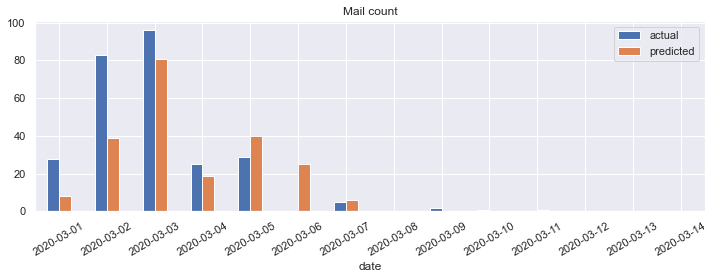

Root Mean Squared Error: 15.4689
Total mail count (actual, predicted): 269, 219


In [22]:
def pred(date1, delta14):
    return date1 + delta14
#     loc = test_start_date - date1
#     date4 = date1 + delta14
#     if delta14 > loc:
#         return date4
#     return date1 + loc

y_pred1 = predict(X_test, params1, lambda x: pred(x['date1'], x['delta14']))
y_pred1_count = y_pred1.groupby(y_pred1.dt.date).count().reindex(test_range, fill_value=0)
test_count(y_true_count, y_pred1_count)

## Model 2 (median delivery time)

Model parameters (median delivery time):

In [23]:
models.append('Model 2 (median delivery time)')

In [24]:
def percentile(n: float):
    def percentile_(df: pd.DataFrame):
        return df.quantile(q=n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

params2 = pd.to_timedelta(fit(X_train, y_train, percentile(0.5)), 's')
params2

point1
1           3 days 04:02:34
11   7 days 13:46:08.500000
13          6 days 19:39:02
2           6 days 16:41:19
21          5 days 17:08:32
23          7 days 10:39:29
25         10 days 04:58:59
5           4 days 15:40:53
50          2 days 11:14:32
53          7 days 01:54:01
9           5 days 21:16:41
Name: delta14, dtype: timedelta64[ns]

Model testing:

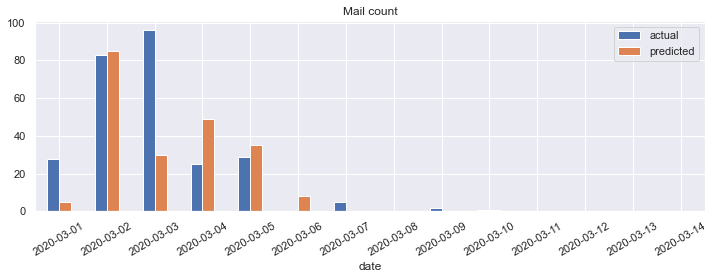

Root Mean Squared Error: 19.9893
Total mail count (actual, predicted): 269, 213


In [25]:
y_pred2 = predict(X_test, params2, lambda x: x['date1'] + x['delta14'])
y_pred2_count = y_pred2.groupby(y_pred2.dt.date).count().reindex(test_range, fill_value=0)
test_count(y_true_count, y_pred2_count)

## Model 3 (Poisson process)

Model parameters ($\lambda$ of Exponential distribution):

In [26]:
models.append('Model 3 (Poisson process)')

In [27]:
params3 = fit(X_train, y_train, lambda x: st.expon.fit(x, floc=0)[1])
pd.to_timedelta(params3, 's')

point1
1     2 days 23:29:27.333333
11    8 days 07:46:54.437500
13    6 days 23:00:40.765957
2     7 days 06:00:50.739130
21    5 days 20:22:26.162162
23    7 days 04:26:58.200000
25   10 days 16:28:39.285714
5     4 days 12:21:22.052631
50    2 days 08:14:52.463157
53    6 days 12:26:22.701754
9     6 days 12:56:52.819699
Name: delta14, dtype: timedelta64[ns]

Parameters for models 1 and 3 are identical, because rate of Exponential distribution equals to a dataset mean.

Model testing:

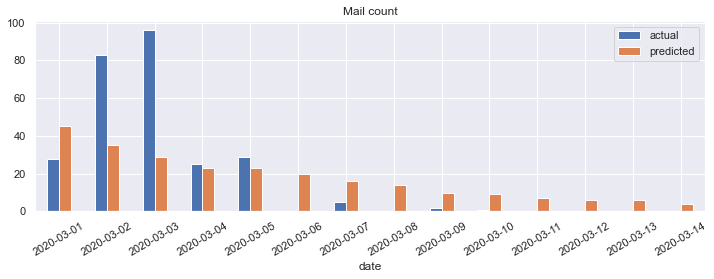

Root Mean Squared Error: 24.0595
Total mail count (actual, predicted): 269, 247


In [28]:
def pred(date1, rate):
    # Generate 100 samples for Exponential distribution
    deltas = st.expon.rvs(scale=rate, size=100, random_state=42)
    # Predict date4 100 times
    date4 = date1 + pd.to_timedelta(pd.Series(deltas), 's')
    # For each day, calculate a probability that a mail will be received on that day
    # Probabilities are calculated for a prediction date range only
    # The probability of receiving mail on other days is zero
    counts = date4.groupby(date4.dt.date).count().reindex(test_range, fill_value=0)
    return (counts / counts.sum()).ravel()

y_pred3 = predict(X_test, params3, lambda x: pred(x['date1'], x['delta14']))
# print(y_pred3)

y_pred3_count = pd.Series(y_pred3.agg(np.sum).round().astype(int), index=test_range)
# We get just an exponential distribution
# I think that a different distribution of mail delivery time will give better results
test_count(y_true_count, y_pred3_count)

## Model 4 (Gamma distribution)

In [29]:
models.append('Model 4 (Gamma distribution)')

Model parameters:

In [30]:
# params4_tuple = fit(X_train, y_train, lambda x: list(st.gamma.fit(x, floc=0)))
# params4_tuple = fit(X_train, y_train, lambda x: list(st.gamma.fit(x, floc=0, fscale=1)))
# Small scales give better results
# Seems that with small scales we just predict some kind of a "mean" delivery time
# Set it to 1 hour:
params4_tuple = fit(X_train, y_train, lambda x: list(st.gamma.fit(x, floc=0, fscale=3600)))
params4 = pd.DataFrame({
    'shape': params4_tuple.apply(lambda x: x[0]),
    'scale': params4_tuple.apply(lambda x: x[2])
})
params4

params4_show = params4.copy()
params4_show['scale'] = pd.to_timedelta(params4['scale'], 's')
params4_show

,shape,scale
point1,,
1,71.052090,01:00:00
11,194.851805,01:00:00
13,154.118220,01:00:00
2,168.650255,01:00:00
21,138.849343,01:00:00
23,171.739558,01:00:00
25,252.751090,01:00:00
5,104.591927,01:00:00
50,55.276946,01:00:00


Model testing:

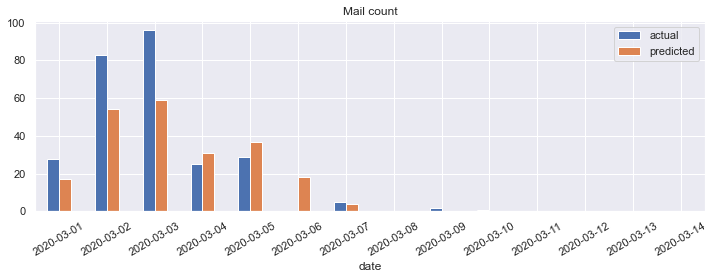

Root Mean Squared Error: 14.0433
Total mail count (actual, predicted): 269, 220


In [31]:
def pred(date1, shape, scale):
    # Generate 100 samples for Exponential distribution
    deltas = st.gamma.rvs(shape, scale=scale, size=100, random_state=42)
    # Predict date4 100 times
    date4 = date1 + pd.to_timedelta(pd.Series(deltas), 's')
    # For each day, calculate a probability that a mail will be received on that day
    # Probabilities are calculated for a prediction date range only
    # The probability of receiving mail on other days is zero
    counts = date4.groupby(date4.dt.date).count().reindex(test_range, fill_value=0)
    counts_sum = counts.sum()
    return (counts / counts_sum).ravel() if counts_sum > 0 else counts.ravel()

y_pred4 = predict(X_test, params4, lambda x: pred(x['date1'], x['shape'], x['scale']))
# print(y_pred4)

y_true_count = y_test.groupby(y_test.dt.date).count().reindex(test_range, fill_value=0)
y_pred4_count = pd.Series(y_pred4.agg(np.sum).round().astype(int), index=test_range)
test_count(y_true_count, y_pred4_count)

## Model 5 (Gamma distribution mean)

In [32]:
models.append('Model 5 (Gamma distribution mean)')

Model parameters (Gamma distribution mean, scale = 1 hour):

In [33]:
def gamma_mean(x):
    params = st.gamma.fit(x, floc=0, fscale=3600)
    return params[0] * params[2]

params5 = pd.to_timedelta(fit(X_train, y_train, gamma_mean), 's')
params5

point1
1     2 days 23:03:07.524466
11    8 days 02:51:06.496765
13    6 days 10:07:05.591347
2     7 days 00:39:00.917241
21    5 days 18:50:57.635672
23    7 days 03:44:22.407543
25   10 days 12:45:03.923840
5     4 days 08:35:30.936582
50    2 days 07:16:37.004117
53    6 days 05:35:42.832098
9     6 days 05:27:48.315558
Name: delta14, dtype: timedelta64[ns]

Model testing:

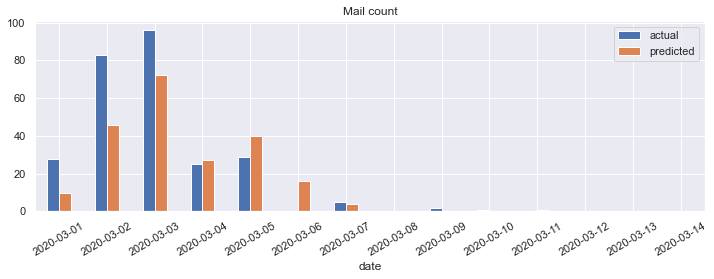

Root Mean Squared Error: 13.7763
Total mail count (actual, predicted): 269, 216


In [34]:
y_pred5 = predict(X_test, params5, lambda x: x['date1'] + x['delta14'])
y_pred5_count = y_pred5.groupby(y_pred5.dt.date).count().reindex(test_range, fill_value=0)
test_count(y_true_count, y_pred5_count)

The mean of Gamma distribution with scale = 1 hour appears to be better than the simple mean.

## Model 6 (conditional probability)

In [35]:
models.append('Model 6 (conditional probability)')

Model parameters (days_until_delivery by point1 and days_since_shipment):

In [36]:
# Calculate total delivery days
days = pd.DataFrame({
    'point1': X_train['point1'],
    'total_days': ((y_train - X_train['date1']) / np.timedelta64(1, 'D')).round().astype('int')
})
# Calculate days_since_shipment
days['days_since_shipment'] = days['total_days'].apply(range)
days = days.explode('days_since_shipment').reset_index(drop=True)
days['days_since_shipment'] = days['days_since_shipment'].astype(int)
# Calculate mean days_until_delivery
days['days_until_delivery'] = days['total_days'] - days['days_since_shipment']
params6 = pd.to_timedelta(days.groupby(['point1', 'days_since_shipment'])['days_until_delivery'].mean(), 'D')
params6

point1  days_since_shipment
1       0                     2 days 16:00:00.000028
        1                     1 days 16:00:00.000028
        2                            1 days 00:00:00
11      0                            8 days 10:30:00
        1                            7 days 10:30:00
                                       ...          
9       16                           3 days 12:00:00
        17                           2 days 12:00:00
        18                           3 days 00:00:00
        19                           2 days 00:00:00
        20                           1 days 00:00:00
Name: days_until_delivery, Length: 128, dtype: timedelta64[ns]

Model testing:

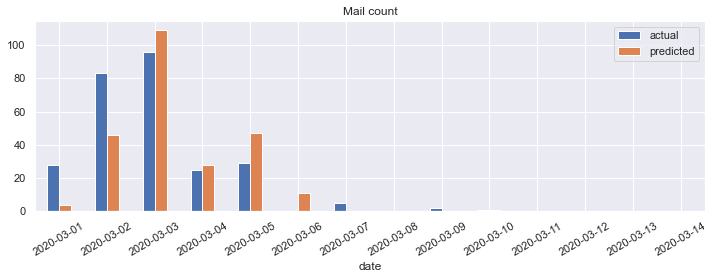

Root Mean Squared Error: 13.6198
Total mail count (actual, predicted): 269, 246


In [37]:
# For example a mail was sent at 2020-02-27 10:00
# We need to predict mail arrival date for March (test_start_date = 2020-03-01)
# At first we calculate days_since_shipment = test_start_date - date1 - 1 day
# We subtract 1 day, because 2020-03-01 is a prediction date, and we know that the mail
# was in transit at 2020-02-27, 2020-02-28, 2020-02-29 (for full 2 days, not 3 days):
# pd.to_datetime('2020-02-29') - pd.to_datetime('2020-02-27')
# The exact value of days_since_shipment is 1.58 days because the mail was sent at 10:00 (not 00:00)
# To eliminate rounding errors, we add 0.5 day
# In other words we calculate the duration between 2020-02-27 10:00 and 2020-02-29 12:00
# The final value of days_since_shipment is 2.08 days
# (pd.to_datetime('2020-03-01') - pd.to_datetime('2020-02-27 10:00')) / np.timedelta64(1, 'D') - 1 + 0.5
features6 = pd.DataFrame({
    'point1': X_test['point1'],
    'days_since_shipment': ((test_start_date - X_test['date1']) / np.timedelta64(1, 'D') - 0.5).round().astype('int')
})

y_pred6 = train_end_date + features6.join(params6, on=['point1', 'days_since_shipment'])['days_until_delivery']
y_pred6_count = y_pred6.groupby(y_pred6.dt.date).count().reindex(test_range, fill_value=0)
test_count(y_true_count, y_pred6_count)

## Model comparision

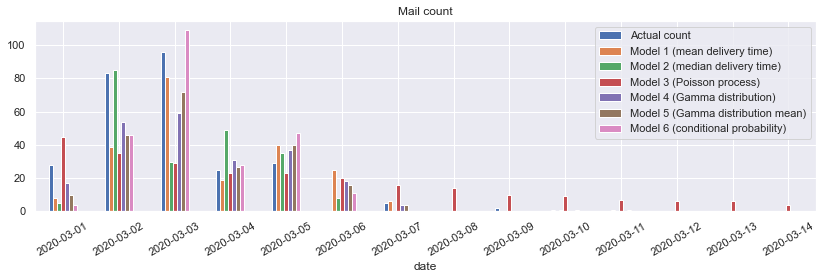

In [38]:
y_pred_counts = [y_pred1_count, y_pred2_count, y_pred3_count, y_pred4_count, y_pred5_count, y_pred6_count]
#results = pd.DataFrame({'predicted_count': })
#results
y_pred_count_df = pd.DataFrame({'Actual count': y_true_count}, index=test_range)
y_pred_count_df
for i in range(len(models)):
    y_pred_count_df[models[i]] = y_pred_counts[i]
ax = y_pred_count_df.plot.bar(figsize=(14,3.5), rot=30)
ax.set_title('Mail count')
ax.set_xticklabels(y_pred_count_df.index.strftime('%Y-%m-%d'))
plt.show()

In [39]:
results = pd.DataFrame({
    'rmse': 0,
    'actual_total_count': y_true_count.sum(),
    'predicted_total_count': 0}, index=models)
results
for i in range(len(models)):
    results.loc[models[i], 'rmse'] = np.sqrt(mean_squared_error(y_true_count, y_pred_counts[i]))
    results.loc[models[i], 'predicted_total_count'] = y_pred_counts[i].sum()
results['missed_mail_count'] = results['actual_total_count'] - results['predicted_total_count']
results['predicted_count_ratio'] = results['predicted_total_count'] / results['actual_total_count']
results

,rmse,actual_total_count,predicted_total_count,missed_mail_count,predicted_count_ratio
Model 1 (mean delivery time),15.468863,269,219,50,0.814126
Model 2 (median delivery time),19.989283,269,213,56,0.791822
Model 3 (Poisson process),24.059450,269,247,22,0.918216
Model 4 (Gamma distribution),14.043300,269,220,49,0.817844
Model 5 (Gamma distribution mean),13.776274,269,216,53,0.802974
Model 6 (conditional probability),13.619838,269,246,23,0.914498
